<font color = blue><font size = 6> 실험설명 </font></font><br>
이미 이전에 1step에서 RNN기반이 1step의 예측에 대해서 좋지 않다는 것을 몸소 경험했다 하지만 Online-learning에서는 좀 다른 결과가 나올까 기대감에 진행해 보았다<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/online_learning_seq2seq']

In [5]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [6]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_499889/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
x_seq

tensor([[[0.7393, 0.7372, 0.7592,  ..., 0.7869, 0.7698, 0.7890]],

        [[0.7372, 0.7592, 0.7416,  ..., 0.7698, 0.7890, 0.7862]],

        [[0.7592, 0.7416, 0.7494,  ..., 0.7890, 0.7862, 0.7815]],

        ...,

        [[0.6223, 0.6152, 0.5962,  ..., 0.7110, 0.6959, 0.6959]],

        [[0.6152, 0.5962, 0.6145,  ..., 0.6959, 0.6959, 0.6893]],

        [[0.5962, 0.6145, 0.6112,  ..., 0.6959, 0.6893, 0.6990]]],
       device='cuda:0')

In [12]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),8*1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 8.0000e-05.


In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 7.6000e-05.
smape 118.40514738047332 %
Adjusting learning rate of group 0 to 7.2200e-05.
smape 83.64690839285738 %
Adjusting learning rate of group 0 to 6.8590e-05.
smape 64.92515691278274 %
Adjusting learning rate of group 0 to 6.5161e-05.
smape 46.73566209555369 %
Adjusting learning rate of group 0 to 6.1902e-05.
smape 33.79328752818861 %
Adjusting learning rate of group 0 to 5.8807e-05.
smape 26.744561711032137 %
Adjusting learning rate of group 0 to 5.5867e-05.
smape 22.25098275279964 %
Adjusting learning rate of group 0 to 5.3074e-05.
smape 18.941827803980885 %
Adjusting learning rate of group 0 to 5.0420e-05.
smape 16.264907348661396 %
Adjusting learning rate of group 0 to 4.7899e-05.
smape 14.095358700213726 %
Adjusting learning rate of group 0 to 4.5504e-05.
smape 12.356355542218997 %
Adjusting learning rate of group 0 to 4.3229e-05.
smape 10.989417449641994 %
Adjusting learning rate of group 0 to 4.1067e-05.
smape 10.022265613187997 %
Adju

In [14]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.7138042664155364 %
SMAPE 4.057687409222126 %
SMAPE 0.3107786087784916 %
SMAPE 2.394641002640128 %
SMAPE 1.3053318690508604 %
SMAPE 0.24724629952106625 %
SMAPE 1.7491028588265183 %
SMAPE 1.852642996236682 %
SMAPE 2.4526241552084684 %
SMAPE 3.245869759470224 %
SMAPE 1.2296017510816455 %
SMAPE 2.8485704753547907 %
SMAPE 3.9417605660855766 %
SMAPE 6.390406124293804 %
SMAPE 7.565143734216689 %
SMAPE 5.222785845398903 %
SMAPE 3.0646706763654947 %
SMAPE 3.772704534232616 %
SMAPE 1.7791455909609795 %
SMAPE 1.7379652224481106 %
SMAPE 1.7786534670740366 %
SMAPE 3.13896126113832 %
SMAPE 1.690688231959939 %
SMAPE 1.1849235016852617 %
SMAPE 2.0854782555252314 %
SMAPE 1.569209199398756 %
SMAPE 2.9091744255274534 %
SMAPE 4.724685575813055 %
SMAPE 1.3306146645918489 %
SMAPE 6.229438826441765 %
SMAPE 3.9152169972658157 %
SMAPE 1.6737431902438402 %
SMAPE 0.032275170456046 %
SMAPE 0.6216840096749365 %
SMAPE 1.5414554718881845 %
SMAPE 3.6627119667828083 %
SMAPE 0.4043413556646555 %
SMAPE 0.4097416

SMAPE 0.8123136442154646 %
SMAPE 5.420243427157402 %
SMAPE 6.405675493180752 %
SMAPE 3.121911281719804 %
SMAPE 2.6399943698197603 %
SMAPE 5.820691842585802 %
SMAPE 0.2488266675500199 %
SMAPE 2.704373560845852 %
SMAPE 0.08102759217069888 %
SMAPE 3.014299003407359 %
SMAPE 2.171867350116372 %
SMAPE 4.388924229890108 %
SMAPE 2.1965060867369175 %
SMAPE 3.9030608534812923 %
SMAPE 5.323447559028864 %
SMAPE 2.608417673036456 %
SMAPE 1.8445834256708622 %
SMAPE 1.2914750296622515 %
SMAPE 4.1550965420901775 %
SMAPE 1.1864733081310987 %
SMAPE 0.8565945741720498 %
SMAPE 4.21861308068037 %
SMAPE 1.1826572986319661 %
SMAPE 4.935485474765301 %
SMAPE 1.6312610832974317 %
SMAPE 0.46322697261348367 %
SMAPE 0.45494070765562356 %
SMAPE 2.8506278786808252 %
SMAPE 5.194746498018503 %
SMAPE 1.1034224824979901 %
SMAPE 5.476037200540304 %
SMAPE 0.8803014922887088 %
SMAPE 0.6296041538007557 %
SMAPE 1.8295260947197676 %
SMAPE 0.4573365873657167 %
SMAPE 2.2111283037811518 %
SMAPE 3.449746668338775 %
SMAPE 3.020684

SMAPE 2.736201509833336 %
SMAPE 0.10197311121737584 %
SMAPE 0.7706995685584843 %
SMAPE 0.4630452636629343 %
SMAPE 0.7624035989865661 %
SMAPE 0.5276751276105642 %
SMAPE 0.9282557759433985 %
SMAPE 0.3245170006994158 %
SMAPE 1.2366774780675769 %
SMAPE 0.584103889297694 %
SMAPE 0.2996553701814264 %
SMAPE 0.09093423117883503 %
SMAPE 0.17312639800366014 %
SMAPE 0.37356449966318905 %
SMAPE 2.171778781339526 %
SMAPE 0.10684109933208676 %
SMAPE 0.41323488811030984 %
SMAPE 0.31133648520335555 %
SMAPE 0.36566593404859304 %
SMAPE 1.377478432841599 %
SMAPE 2.371061649173498 %
SMAPE 0.7823736765421927 %
SMAPE 0.5521162948571146 %
SMAPE 0.32946393080055714 %
SMAPE 1.210177568718791 %
SMAPE 0.9308849489316343 %
SMAPE 0.020335462605885368 %
SMAPE 1.8704309854656458 %
SMAPE 0.270166187081486 %
SMAPE 0.8022400224581361 %
SMAPE 1.3287056256085634 %
SMAPE 1.5516238361597061 %
SMAPE 0.1463846318074502 %
SMAPE 0.832650561351329 %
SMAPE 0.0673264408542309 %
SMAPE 0.6205814150162041 %
SMAPE 0.9241204941645265 

SMAPE 1.1471988027915359 %
SMAPE 0.6130573619157076 %
SMAPE 1.3561161756515503 %
SMAPE 0.11434722342528401 %
SMAPE 2.5935486424714327 %
SMAPE 1.0473061334341764 %
SMAPE 1.1236356310546398 %
SMAPE 0.9464222397655249 %
SMAPE 0.013353967931351463 %
SMAPE 0.004040865502787483 %
SMAPE 0.4837539186701179 %
SMAPE 1.2623996138572693 %
SMAPE 0.10676915710791945 %
SMAPE 1.4013416664674878 %
SMAPE 0.07576905406313017 %
SMAPE 0.8183494568802416 %
SMAPE 0.6490440182387829 %
SMAPE 0.15351156145334244 %
SMAPE 0.00583237310527096 %
SMAPE 0.7665478154085577 %
SMAPE 1.4247715175151825 %
SMAPE 0.956432005390525 %
SMAPE 0.1643536357441917 %
SMAPE 0.24739628727547827 %
SMAPE 1.5377968130633235 %
SMAPE 1.7920721396803854 %
SMAPE 0.26525178691372275 %
SMAPE 0.22275201953016222 %
SMAPE 0.8453338742256165 %
SMAPE 0.9545736582949758 %
SMAPE 0.6217645923607051 %
SMAPE 0.525258285459131 %
SMAPE 0.47801476344466215 %
SMAPE 1.5801780149340627 %
SMAPE 0.2196042318828404 %
SMAPE 0.6573073850013316 %
SMAPE 1.070106682

SMAPE 0.3721588219050318 %
SMAPE 2.087062871083617 %
SMAPE 1.2417796226218343 %
SMAPE 0.5370980417355895 %
SMAPE 0.6489315400831401 %
SMAPE 0.9052150677889584 %
SMAPE 0.39694112050347025 %
SMAPE 2.212947940453887 %
SMAPE 0.6123317796736956 %
SMAPE 4.030725680291653 %
SMAPE 1.3125105015933514 %
SMAPE 0.8530462672933937 %
SMAPE 0.5171077875420451 %
SMAPE 0.19086242839694023 %
SMAPE 2.022439682856202 %
SMAPE 0.18575978255830705 %
SMAPE 1.0325979897752404 %
SMAPE 0.5657261162996292 %
SMAPE 0.6097806771285832 %
SMAPE 0.25760487862862647 %
SMAPE 1.4028998045250773 %
SMAPE 1.022664988413453 %
SMAPE 0.8187402626499535 %
SMAPE 1.2908128751441836 %
SMAPE 0.39736146037466824 %
SMAPE 1.193864387460053 %
SMAPE 0.8906170437112451 %
SMAPE 0.8104834454134107 %
SMAPE 0.83187989378348 %
SMAPE 0.8640005895867944 %
SMAPE 0.8607634953223168 %
SMAPE 0.8016835283488035 %
SMAPE 1.692241171374917 %
SMAPE 0.3381651707459241 %
SMAPE 2.368724899366498 %
SMAPE 1.4520520474761724 %
SMAPE 0.48499377211555833 %
SMAPE

SMAPE 2.9304492864757776 %
SMAPE 1.1126313218846917 %
SMAPE 0.756099714897573 %
SMAPE 2.9003069680184126 %
SMAPE 1.5699613392353058 %
SMAPE 3.421788264065981 %
SMAPE 1.2867723479866982 %
SMAPE 0.26688826584722847 %
SMAPE 1.3960648505017161 %
SMAPE 1.1861354745924473 %
SMAPE 1.7745217774063349 %
SMAPE 0.16101645841263235 %
SMAPE 2.440516196191311 %
SMAPE 4.935982275754213 %
SMAPE 3.0757125057280064 %
SMAPE 1.8679890893399715 %
SMAPE 2.5485937613993883 %
SMAPE 1.010469015687704 %
SMAPE 0.781812504399568 %
SMAPE 0.8767829886637627 %
SMAPE 1.1507806312292814 %
SMAPE 4.872389238327742 %
SMAPE 3.063304204493761 %
SMAPE 5.816438730806112 %
SMAPE 0.5747664463706315 %
SMAPE 0.4835654394701123 %
SMAPE 2.941584512591362 %
SMAPE 1.4898198880255222 %
SMAPE 0.5002185164485127 %
SMAPE 1.77549253590405 %
SMAPE 0.3775354288518429 %
SMAPE 0.10362657195037173 %
SMAPE 2.4579601380974054 %
SMAPE 2.6090724878013134 %
SMAPE 7.9648823514580736 %
SMAPE 2.4960918743163347 %
SMAPE 2.770617986097932 %
SMAPE 2.293

SMAPE 0.9661367302760482 %
SMAPE 2.3889067843556404 %
SMAPE 0.9059477541595697 %
SMAPE 3.565144523978234 %
SMAPE 4.29131718352437 %
SMAPE 2.457392107695341 %
SMAPE 1.3058875864371657 %
SMAPE 0.38669900223612785 %
SMAPE 0.8819978954270481 %
SMAPE 1.1234573610126972 %
SMAPE 1.397738505154848 %
SMAPE 1.8217576425522564 %
SMAPE 1.772475218400359 %
SMAPE 1.058828104287386 %
SMAPE 3.4770924523472786 %
SMAPE 2.377306519076228 %
SMAPE 1.2958426317200065 %
SMAPE 2.187904192134738 %
SMAPE 1.3574982192367315 %
SMAPE 1.7109841015189884 %
SMAPE 2.9904705453664064 %
SMAPE 0.42627338017337024 %
SMAPE 0.1710635200724937 %
SMAPE 0.001440881055572163 %
SMAPE 0.8496557818725705 %
SMAPE 2.1307704392820597 %
SMAPE 0.16829958895687014 %
SMAPE 0.08512538817103632 %
SMAPE 0.5723693533800542 %
SMAPE 1.3106748880818486 %
SMAPE 2.767524655908346 %
SMAPE 7.078066386282444 %
SMAPE 1.8649502862244844 %
SMAPE 0.18615172774298117 %
SMAPE 5.293238144367933 %
SMAPE 5.415824994444847 %
SMAPE 6.89073371142149 %
SMAPE 8.6

SMAPE 0.8840580061078072 %
SMAPE 0.4571847543120384 %
SMAPE 0.6139080598950386 %
SMAPE 0.6398051823489368 %
SMAPE 1.0039902590215206 %
SMAPE 0.7033864734694362 %
SMAPE 0.22871844039764255 %
SMAPE 0.21087125060148537 %
SMAPE 1.345350886695087 %
SMAPE 0.22926247247960418 %
SMAPE 0.33144959970377386 %
SMAPE 0.25160218228120357 %
SMAPE 0.5385437831282616 %
SMAPE 1.1804421674460173 %
SMAPE 0.7874061074107884 %
SMAPE 0.385890661040321 %
SMAPE 1.2029861230403185 %
SMAPE 0.9707663208246231 %
SMAPE 0.09784090935136192 %
SMAPE 0.003876285972935989 %
SMAPE 0.5962358135730028 %
SMAPE 0.9673130279406906 %
SMAPE 1.0674756495282054 %
SMAPE 0.9597387546673417 %
SMAPE 1.0037981867790222 %
SMAPE 0.22131242952309552 %
SMAPE 1.1966534471139312 %
SMAPE 0.10252202523406595 %
SMAPE 0.7764097359031439 %
SMAPE 0.024987491752767706 %
SMAPE 0.5031741564162076 %
SMAPE 0.3238768798764795 %
SMAPE 0.011003319021710922 %
SMAPE 1.902334425598383 %
SMAPE 0.7855890770442784 %
SMAPE 0.7104244353249669 %
SMAPE 0.330479893

SMAPE 0.9483162481337786 %
SMAPE 0.5088028581812978 %
SMAPE 0.8070347425527871 %
SMAPE 1.0438319938257337 %
SMAPE 1.1438508108258247 %
SMAPE 0.9011192666366695 %
SMAPE 1.5040406621992588 %
SMAPE 0.49536769138649106 %
SMAPE 0.6119376057758927 %
SMAPE 0.5032910103909671 %
SMAPE 1.1169227175414562 %
SMAPE 0.9097909396514297 %
SMAPE 0.36494650528766215 %
SMAPE 0.0367605338314263 %
SMAPE 1.4638901175931096 %
SMAPE 0.9907391471788287 %
SMAPE 0.029585361466729413 %
SMAPE 0.801715205423534 %
SMAPE 1.267345647327602 %
SMAPE 1.201206624507904 %
SMAPE 0.009676660693983763 %
SMAPE 0.8187516732141376 %
SMAPE 0.5227576373144984 %
SMAPE 0.5647871028631926 %
SMAPE 1.7913319878280165 %
SMAPE 0.7874447051435709 %
SMAPE 0.5060768076218665 %
SMAPE 0.604474388062954 %
SMAPE 2.8948276452720165 %
SMAPE 0.66291364422068 %
SMAPE 1.6224460601806643 %
SMAPE 0.8452116288244724 %
SMAPE 0.6573180998675525 %
SMAPE 1.674141839146614 %
SMAPE 0.10053377837175503 %
SMAPE 0.007628186801355242 %
SMAPE 0.8613186329603195 %

SMAPE 0.9746256330981852 %
SMAPE 1.2576221711933613 %
SMAPE 1.3117887703701854 %
SMAPE 0.8699302049353718 %
SMAPE 1.4423536583781242 %
SMAPE 2.1014147587120533 %
SMAPE 2.8162961527705193 %
SMAPE 0.4489592944737524 %
SMAPE 2.501926900818944 %
SMAPE 1.2571995789185166 %
SMAPE 1.320342781022191 %
SMAPE 2.3502640686929226 %
SMAPE 2.729365512728691 %
SMAPE 3.033365024253726 %
SMAPE 0.3876012375112623 %
SMAPE 0.4774291559588164 %
SMAPE 1.6137936199083924 %
SMAPE 0.5919307237491012 %
SMAPE 2.4434031788259745 %
SMAPE 1.6053081238642335 %
SMAPE 2.527263754978776 %
SMAPE 0.18989991076523438 %
SMAPE 2.8570993449538946 %
SMAPE 1.8271352294832468 %
SMAPE 2.9166059345006943 %
SMAPE 2.2157775573432446 %
SMAPE 19.305784717202187 %
SMAPE 2.1339440047740936 %
SMAPE 11.95082325488329 %
SMAPE 15.755338460206985 %
SMAPE 18.14555335044861 %
SMAPE 16.629653811454773 %
SMAPE 9.879595875740051 %
SMAPE 9.257487177848816 %
SMAPE 1.01824039965868 %
SMAPE 2.8638011384755373 %
SMAPE 8.288029246032238 %
SMAPE 7.0773

SMAPE 1.6289735957980156 %
SMAPE 5.916539039462805 %
SMAPE 4.9910497814416885 %
SMAPE 0.9065080611035228 %
SMAPE 1.6298651900142431 %
SMAPE 4.548435762524605 %
SMAPE 1.8938548378646374 %
SMAPE 0.7016450143419206 %
SMAPE 1.0997687261551619 %
SMAPE 8.15284789353609 %
SMAPE 0.52786685526371 %
SMAPE 5.275445871055126 %
SMAPE 6.032732203602791 %
SMAPE 0.27664811472641304 %
SMAPE 0.03897053211602497 %
SMAPE 4.581469036638737 %
SMAPE 3.9913367554545403 %
SMAPE 4.7010937333106995 %
SMAPE 3.370790857821703 %
SMAPE 1.3049069344997406 %
SMAPE 4.152346935123205 %
SMAPE 6.276678439229727 %
SMAPE 4.257742676883936 %
SMAPE 4.00447878614068 %
SMAPE 4.0647813975811005 %
SMAPE 3.894906248897314 %
SMAPE 4.99454490095377 %
SMAPE 1.9613095019012692 %
SMAPE 0.9990632077679038 %
SMAPE 0.9267957839183509 %
SMAPE 0.8488077837973833 %
SMAPE 0.7592974836006761 %
SMAPE 0.3126359776360914 %
SMAPE 4.089838717132807 %
SMAPE 4.149808324873447 %
SMAPE 4.643532540649176 %
SMAPE 5.137546773999929 %
SMAPE 0.7925292551517

SMAPE 3.358259294182062 %
SMAPE 3.2283474244177346 %
SMAPE 2.248449904844165 %
SMAPE 0.6329426108859479 %
SMAPE 2.4279968589544296 %
SMAPE 1.6274118963629007 %
SMAPE 1.6902171634137633 %
SMAPE 0.35416528140194714 %
SMAPE 2.0375262778252363 %
SMAPE 0.8098143669776618 %
SMAPE 1.6803512666374445 %
SMAPE 2.222168058156967 %
SMAPE 0.4956684708595276 %
SMAPE 0.13152687851106748 %
SMAPE 3.9515859447419643 %
SMAPE 1.0878416886553168 %
SMAPE 0.62120226258412 %
SMAPE 0.02175844254901449 %
SMAPE 3.525343034416437 %
SMAPE 0.07977064566284753 %
SMAPE 3.4615747928619385 %
SMAPE 0.20437433733604846 %
SMAPE 0.3109552185051143 %
SMAPE 0.1331037910131272 %
SMAPE 1.5227779624983668 %
SMAPE 1.8251391556113958 %
SMAPE 0.3777878135442734 %
SMAPE 1.7474887259304523 %
SMAPE 0.005305791160566287 %
SMAPE 2.322542067617178 %
SMAPE 0.22205770702566952 %
SMAPE 3.221948036924004 %
SMAPE 2.3000498190522194 %
SMAPE 2.6385064404457808 %
SMAPE 0.015031449297950417 %
SMAPE 1.8452412094920874 %
SMAPE 0.056751078279376095

SMAPE 0.09798229965963401 %
SMAPE 0.237254808540456 %
SMAPE 0.6116240415722132 %
SMAPE 0.3704351221676916 %
SMAPE 1.459471178241074 %
SMAPE 1.7482638712972403 %
SMAPE 0.2880919352173805 %
SMAPE 0.026066606790038804 %
SMAPE 0.023655650088869606 %
SMAPE 2.0408453568816185 %
SMAPE 0.9518443532288074 %
SMAPE 1.3691859394311905 %
SMAPE 1.7153063379228113 %
SMAPE 0.028557799221175628 %
SMAPE 1.1707251789048314 %
SMAPE 1.1863781483843923 %
SMAPE 0.004154726189440794 %
SMAPE 2.286976171657443 %
SMAPE 0.5790918278507888 %
SMAPE 0.2898599933832884 %
SMAPE 0.005242684515778251 %
SMAPE 0.5263129724189639 %
SMAPE 1.1915012244135141 %
SMAPE 0.39243412809446454 %
SMAPE 0.012666960509228888 %
SMAPE 0.016516150139516128 %
SMAPE 1.1582761267200112 %
SMAPE 0.3002261423971504 %
SMAPE 0.5610639681108296 %
SMAPE 0.10499258237541653 %
SMAPE 0.6048899749293923 %
SMAPE 1.0492120934650302 %
SMAPE 0.6307189017534256 %
SMAPE 0.642662295140326 %
SMAPE 0.16844847484026104 %
SMAPE 1.9121019076555965 %
SMAPE 1.123128

SMAPE 0.9220052855089306 %
SMAPE 0.7795625342987478 %
SMAPE 0.6882518636994064 %
SMAPE 0.0386284917260582 %
SMAPE 0.055081117431200255 %
SMAPE 0.05555418278663638 %
SMAPE 1.0260967100039124 %
SMAPE 0.11658687930321322 %
SMAPE 0.004363294265544937 %
SMAPE 1.9817835241556165 %
SMAPE 1.4571731369942427 %
SMAPE 3.1789885386824612 %
SMAPE 3.540912177413702 %
SMAPE 3.012181041762233 %
SMAPE 1.233260614797473 %
SMAPE 1.850440453737974 %
SMAPE 1.9522359129041433 %
SMAPE 1.61046146415174 %
SMAPE 0.7734289336949587 %
SMAPE 0.0036801616103758756 %
SMAPE 1.1090138759464025 %
SMAPE 1.2543956153094769 %
SMAPE 2.0152048505842686 %
SMAPE 1.3637242140248418 %
SMAPE 0.8987230248749256 %
SMAPE 1.4141865484416485 %
SMAPE 1.8377758413553238 %
SMAPE 3.1302035134285684 %
SMAPE 1.7854014243930578 %
SMAPE 1.5884269168600438 %
SMAPE 1.5408171638846397 %
SMAPE 1.8742797132581472 %
SMAPE 0.7958257542923094 %
SMAPE 0.2338599102804437 %
SMAPE 1.8455670792609453 %
SMAPE 0.3496781561989337 %
SMAPE 0.01277804458898401

SMAPE 2.572266971692443 %
SMAPE 1.2888418789952993 %
SMAPE 2.5967119820415974 %
SMAPE 1.528527483344078 %
SMAPE 3.175112461671233 %
SMAPE 1.6666424479335546 %
SMAPE 4.234743285924196 %
SMAPE 0.9188934750854969 %
SMAPE 2.810636293143034 %
SMAPE 2.4850287549197674 %
SMAPE 3.4490622505545616 %
SMAPE 2.9900189265608788 %
SMAPE 0.041268175438361254 %
SMAPE 0.0018166450681036392 %
SMAPE 0.19136469683144242 %
SMAPE 0.8393322243355215 %
SMAPE 0.5689344285055995 %
SMAPE 1.922984477132559 %
SMAPE 3.4734025858342648 %
SMAPE 1.7283616550266743 %
SMAPE 3.9500402137637143 %
SMAPE 6.146743077784777 %
SMAPE 4.41129807010293 %
SMAPE 0.07054795118165202 %
SMAPE 3.562705274671316 %
SMAPE 1.811329772695899 %
SMAPE 0.8427251414395869 %
SMAPE 0.00287219220786028 %
SMAPE 4.760785166174173 %
SMAPE 3.2631322108209133 %
SMAPE 0.46436022757552564 %
SMAPE 0.4307109424844384 %
SMAPE 1.8372913524508476 %
SMAPE 2.4845259208232164 %
SMAPE 0.5669021848589182 %
SMAPE 2.0424866657704115 %
SMAPE 0.0628396791976229 %
SMAP

SMAPE 0.7644101553596556 %
SMAPE 2.1505315601825714 %
SMAPE 5.984560076147318 %
SMAPE 0.4241218254901469 %
SMAPE 0.016544287364737897 %
SMAPE 6.578937329351903 %
SMAPE 3.1034292709082365 %
SMAPE 6.8412596732378015 %
SMAPE 0.9141189260408282 %
SMAPE 1.5138020189478993 %
SMAPE 0.9994766460731626 %
SMAPE 0.5230872053653002 %
SMAPE 1.8579063881188633 %
SMAPE 1.3945350870490074 %
SMAPE 4.31408453732729 %
SMAPE 2.9159283824265003 %
SMAPE 0.0015660452471237818 %
SMAPE 0.7072916058823466 %
SMAPE 4.608064524829388 %
SMAPE 7.681005127727985 %
SMAPE 1.6686046989634633 %
SMAPE 2.5726273581385612 %
SMAPE 1.4173572305589914 %
SMAPE 2.7248767390847206 %
SMAPE 0.5689156441949308 %
SMAPE 2.1193282827734947 %
SMAPE 0.8754694224335254 %
SMAPE 0.2574504620861262 %
SMAPE 1.6577312471345067 %
SMAPE 1.6190906995907428 %
SMAPE 1.3827351164072752 %
SMAPE 2.2551067527383566 %
SMAPE 4.1279499270021915 %
SMAPE 1.2641031900420785 %
SMAPE 3.141975339502096 %
SMAPE 1.0435421792790294 %
SMAPE 0.904353569727391 %
SMAP

SMAPE 0.05560163923200889 %
SMAPE 0.02272689436284736 %
SMAPE 1.1900019627064466 %
SMAPE 0.39739672909490764 %
SMAPE 0.532766327727586 %
SMAPE 0.11961159779457375 %
SMAPE 0.9938594447448849 %
SMAPE 0.2945843448396772 %
SMAPE 1.532218186184764 %
SMAPE 1.5107034211978316 %
SMAPE 0.35559789603576064 %
SMAPE 0.10208506551862227 %
SMAPE 0.9850570792332292 %
SMAPE 0.20795560651458797 %
SMAPE 0.22028614534065127 %
SMAPE 0.645628659054637 %
SMAPE 1.0829472364857793 %
SMAPE 0.9499693987891078 %
SMAPE 1.8574198652058842 %
SMAPE 0.9616389526054264 %
SMAPE 0.05210475627126243 %
SMAPE 0.26003652811050415 %
SMAPE 4.528524704277515 %
SMAPE 5.042742911726236 %
SMAPE 2.201196238398552 %
SMAPE 3.7192633636295795 %
SMAPE 2.5927707217633724 %
SMAPE 1.530412488617003 %
SMAPE 0.10615431820042431 %
SMAPE 0.5164323593489826 %
SMAPE 0.2547072952147573 %
SMAPE 1.7087533120065928 %
SMAPE 0.0900218196620699 %
SMAPE 0.8400398315861821 %
SMAPE 1.3423811290413141 %
SMAPE 0.8996374811977148 %
SMAPE 0.4004913282115012

SMAPE 1.5362588008865714 %
SMAPE 0.2063140735263005 %
SMAPE 0.3117312255781144 %
SMAPE 0.25909706531092525 %
SMAPE 0.7207594471983612 %
SMAPE 0.05304970228326056 %
SMAPE 0.4703023578040302 %
SMAPE 0.6687196749262512 %
SMAPE 1.0629091449081898 %
SMAPE 0.06524959973467048 %
SMAPE 0.18836405815090984 %
SMAPE 0.22158897446934134 %
SMAPE 0.7032748889178038 %
SMAPE 0.3176919936668128 %
SMAPE 1.3614755580201745 %
SMAPE 1.10425010509789 %
SMAPE 0.5363386641256511 %
SMAPE 1.0808496475219727 %
SMAPE 0.03119835115700198 %
SMAPE 0.6684551257640123 %
SMAPE 0.01134268102211422 %
SMAPE 1.6601760778576133 %
SMAPE 1.2529055019840598 %
SMAPE 0.3694231726694852 %
SMAPE 0.804714548867196 %
SMAPE 0.8319705058820546 %
SMAPE 0.21294379443861544 %
SMAPE 0.5126912971027195 %
SMAPE 0.021944492983358543 %
SMAPE 0.3868015801999718 %
SMAPE 0.0006247237869274613 %
SMAPE 1.3028061939403415 %
SMAPE 0.09545823649386875 %
SMAPE 0.9944838611409068 %
SMAPE 0.9319977182894946 %
SMAPE 0.7065381403081119 %
SMAPE 1.341034748

SMAPE 5.5900379084050655 %
SMAPE 6.421842560172081 %
SMAPE 5.971760146319866 %
SMAPE 5.3570773005485535 %
SMAPE 4.889809139072895 %
SMAPE 4.148801561444998 %
SMAPE 3.9168770574033256 %
SMAPE 3.2101827673614025 %
SMAPE 2.1527715362608433 %
SMAPE 1.4978367006406188 %
SMAPE 3.574256170541048 %
SMAPE 1.6307575963437557 %
SMAPE 0.3676464718300849 %
SMAPE 0.05606986540570347 %
SMAPE 0.05056435145525029 %
SMAPE 0.4104507123120129 %
SMAPE 0.6676236912608147 %
SMAPE 0.6207347535528243 %
SMAPE 0.13720135926268995 %
SMAPE 1.1349934190511703 %
SMAPE 0.49654639372602105 %
SMAPE 0.4518425678834319 %
SMAPE 0.8039094978012146 %
SMAPE 0.7219475181773305 %
SMAPE 1.211591257713735 %
SMAPE 1.9484346974641087 %
SMAPE 1.3942015124484897 %
SMAPE 0.45396090182475746 %
SMAPE 0.18686215754132718 %
SMAPE 1.136381738819182 %
SMAPE 0.6911348742432892 %
SMAPE 0.5744685470126569 %
SMAPE 0.6659131455235183 %
SMAPE 0.29003555281087756 %
SMAPE 0.9942524889484048 %
SMAPE 0.7138000414706767 %
SMAPE 0.578104006126523 %
SM

SMAPE 2.886767638847232 %
SMAPE 3.080631909891963 %
SMAPE 0.6231693415902555 %
SMAPE 0.2441852882038802 %
SMAPE 0.009803729140969608 %
SMAPE 1.2484235651791096 %
SMAPE 6.348371483385564 %
SMAPE 0.4740711024496704 %
SMAPE 0.9418555218726397 %
SMAPE 0.9732233183458447 %
SMAPE 1.6257300842553377 %
SMAPE 0.5723649384453893 %
SMAPE 0.9785186247900128 %
SMAPE 2.205869622528553 %
SMAPE 0.15099134971387684 %
SMAPE 5.9971471056342125 %
SMAPE 5.6168752163648605 %
SMAPE 0.8111843145452441 %
SMAPE 0.09973186695424374 %
SMAPE 0.46236562426202005 %
SMAPE 0.15826556377578527 %
SMAPE 3.506218001246452 %
SMAPE 0.5573840131983161 %
SMAPE 0.20845251716673374 %
SMAPE 0.5617953231558204 %
SMAPE 3.432979512959719 %
SMAPE 1.6146693108603358 %
SMAPE 1.4645242495462298 %
SMAPE 0.12474257347639651 %
SMAPE 1.7092478591948748 %
SMAPE 0.025524107794637985 %
SMAPE 0.4640172440558672 %
SMAPE 0.6569010601378977 %
SMAPE 0.1022893008121173 %
SMAPE 2.3566982820630074 %
SMAPE 3.0905763898044825 %
SMAPE 0.6623605731874704

SMAPE 0.5445163259282708 %
SMAPE 0.263067300315015 %
SMAPE 2.6036445666104555 %
SMAPE 2.954998552799225 %
SMAPE 1.5266782445833087 %
SMAPE 6.701206080615521 %
SMAPE 5.855712402611971 %
SMAPE 1.4142707558348775 %
SMAPE 2.226647451519966 %
SMAPE 1.2780874203890562 %
SMAPE 1.8074696995317936 %
SMAPE 1.8453109785914423 %
SMAPE 0.23991757037583739 %
SMAPE 2.1304141245782375 %
SMAPE 2.727880736812949 %
SMAPE 2.7951293122023344 %
SMAPE 0.9703410025686026 %
SMAPE 1.625698331743479 %
SMAPE 2.502867152914405 %
SMAPE 2.1320703886449337 %
SMAPE 0.7829238562844694 %
SMAPE 3.319186389446258 %
SMAPE 2.1903213299810886 %
SMAPE 0.301833373028785 %
SMAPE 1.2449845634400845 %
SMAPE 0.3672134743537754 %
SMAPE 4.99568922445178 %
SMAPE 6.6137610003352165 %
SMAPE 2.582595320418477 %
SMAPE 0.07102672504333896 %
SMAPE 0.3884136073756963 %
SMAPE 0.002436852432893488 %
SMAPE 0.39409230952151114 %
SMAPE 1.638996919617057 %
SMAPE 2.1276021227240562 %
SMAPE 6.258638706058265 %
SMAPE 2.761809518560767 %
SMAPE 3.7232

SMAPE 0.44363720854744315 %
SMAPE 0.8839129349216818 %
SMAPE 0.3994200162123889 %
SMAPE 0.09375396987888962 %
SMAPE 0.29052417795173824 %
SMAPE 0.04618129919663261 %
SMAPE 2.1138570345938206 %
SMAPE 0.6454430967569351 %
SMAPE 1.9883292820304634 %
SMAPE 0.6358777852728963 %
SMAPE 0.561320364009589 %
SMAPE 0.2578253913670778 %
SMAPE 0.5142587278969586 %
SMAPE 0.7003351063467562 %
SMAPE 0.445518440566957 %
SMAPE 0.5465078996494412 %
SMAPE 0.6399877620860934 %
SMAPE 0.7321972297504544 %
SMAPE 0.15007098962087184 %
SMAPE 0.0017092063688650683 %
SMAPE 1.3591280905529857 %
SMAPE 0.5957897594198585 %
SMAPE 1.2493208348751068 %
SMAPE 0.5100301601924002 %
SMAPE 0.2540325073059648 %
SMAPE 0.15569096466060728 %
SMAPE 0.286874711047858 %
SMAPE 1.1573083931580186 %
SMAPE 0.08138980431249365 %
SMAPE 0.22069107077550143 %
SMAPE 1.0787915121763945 %
SMAPE 2.332196181640029 %
SMAPE 0.41976336343213916 %
SMAPE 2.336617276072502 %
SMAPE 1.5271033952012658 %
SMAPE 0.7846464430913328 %
SMAPE 1.3742656111717

SMAPE 0.41978166531771416 %
SMAPE 1.1164943678304553 %
SMAPE 0.8078226931393145 %
SMAPE 0.8623939035460352 %
SMAPE 1.1823889054358006 %
SMAPE 1.1845433786511421 %
SMAPE 1.143925123848021 %
SMAPE 0.6634491481818259 %
SMAPE 0.7262081331573427 %
SMAPE 0.6551314522512257 %
SMAPE 0.0023268140201224696 %
SMAPE 0.9652207680046558 %
SMAPE 2.455418061465025 %
SMAPE 0.8886315254494548 %
SMAPE 1.5832551931962373 %
SMAPE 1.278029404580593 %
SMAPE 0.4464923841878772 %
SMAPE 0.8305883812718095 %
SMAPE 0.5179826347157359 %
SMAPE 0.11967860470758751 %
SMAPE 0.5817611711099744 %
SMAPE 1.527839770540595 %
SMAPE 0.9556933855637908 %
SMAPE 1.0586769124493003 %
SMAPE 0.7384009966626763 %
SMAPE 0.03763944195611657 %
SMAPE 0.7194906543008983 %
SMAPE 0.4546162630431354 %
SMAPE 0.1418929640785791 %
SMAPE 0.10599692579125987 %
SMAPE 0.4099415682721883 %
SMAPE 0.3091912744566798 %
SMAPE 0.09228586775134318 %
SMAPE 0.33185321232303977 %
SMAPE 1.3001436423510313 %
SMAPE 1.96620081551373 %
SMAPE 0.2952868100255728 

SMAPE 1.2035083658993244 %
SMAPE 1.0766796497628093 %
SMAPE 1.9251734726130965 %
SMAPE 1.5742186503484845 %
SMAPE 0.7795145539566875 %
SMAPE 0.382610987406224 %
SMAPE 0.2724398704012856 %
SMAPE 0.5705243265256286 %
SMAPE 1.3957377430051565 %
SMAPE 0.046403079126008606 %
SMAPE 0.6260169949382544 %
SMAPE 1.1125752488151193 %
SMAPE 0.775975882075727 %
SMAPE 1.6019558049738407 %
SMAPE 0.7209523203782737 %
SMAPE 0.13663838084903546 %
SMAPE 0.1740778918028809 %
SMAPE 2.327754268422723 %
SMAPE 0.4800317417830229 %
SMAPE 0.08629922510181132 %
SMAPE 0.0031581789223054106 %
SMAPE 1.3133616968989372 %
SMAPE 1.6256729438900948 %
SMAPE 1.8967315517365932 %
SMAPE 0.43318335758522153 %
SMAPE 2.051811082288623 %
SMAPE 0.01846173085559144 %
SMAPE 0.0761891034958353 %
SMAPE 0.08474101397769118 %
SMAPE 1.0147986393421888 %
SMAPE 0.3490361098665744 %
SMAPE 0.7294954219833016 %
SMAPE 2.8978412691503763 %
SMAPE 2.0888425689190626 %
SMAPE 0.012893736031259097 %
SMAPE 1.6988186407834294 %
SMAPE 2.335934434086

SMAPE 3.2802649624645714 %
SMAPE 0.836534300353378 %
SMAPE 1.3411447778344154 %
SMAPE 3.0606490783393383 %
SMAPE 2.8728513848036528 %
SMAPE 3.666631925851107 %
SMAPE 0.5917792161926627 %
SMAPE 1.5983452070504427 %
SMAPE 3.4176946952939034 %
SMAPE 5.5001240484416485 %
SMAPE 0.3137517118593678 %
SMAPE 0.014420711336583738 %
SMAPE 0.15537587922881357 %
SMAPE 0.002381046668858744 %
SMAPE 3.587892390787602 %
SMAPE 4.4843941032886505 %
SMAPE 0.7672580359503627 %
SMAPE 0.16490806551882997 %
SMAPE 1.5612537506967783 %
SMAPE 0.12180366467009662 %
SMAPE 0.38642665138468146 %
SMAPE 6.2471548691391945 %
SMAPE 2.1281496323645115 %
SMAPE 1.1734581338241696 %
SMAPE 0.21223588805878535 %
SMAPE 6.054702993482351 %
SMAPE 5.885786924511194 %
SMAPE 0.7653269902803004 %
SMAPE 1.428619741462171 %
SMAPE 2.1430192701518536 %
SMAPE 2.3564841486513615 %
SMAPE 2.384779889136553 %
SMAPE 2.8361816946417093 %
SMAPE 2.420630695298314 %
SMAPE 0.5156036249827594 %
SMAPE 2.4736630339175463 %
SMAPE 2.6966647654771805 %


SMAPE 1.659309856593609 %
SMAPE 2.9840716421604156 %
SMAPE 1.1621197490021586 %
SMAPE 0.05656779737932994 %
SMAPE 4.360617578029633 %
SMAPE 2.832249816507101 %
SMAPE 7.294870346784592 %
SMAPE 1.1739783240482211 %
SMAPE 1.5477715395390987 %
SMAPE 0.5801107590086758 %
SMAPE 0.15496494015678763 %
SMAPE 0.7102407710626721 %
SMAPE 2.748078726232052 %
SMAPE 1.5801050821319222 %
SMAPE 3.9759515784680843 %
SMAPE 2.3328519854694605 %
SMAPE 2.6093905586749315 %
SMAPE 2.5497642811387777 %
SMAPE 5.278034947812557 %
SMAPE 0.3262684461660683 %
SMAPE 1.2394395722076297 %
SMAPE 1.950184302404523 %
SMAPE 1.6157768592238428 %
SMAPE 1.5921872248873112 %
SMAPE 0.10891287453705445 %
SMAPE 3.7847927957773213 %
SMAPE 0.465165039524436 %
SMAPE 0.8530143005773425 %
SMAPE 0.482019963208586 %
SMAPE 0.00391380144986897 %
SMAPE 0.42425792641006416 %
SMAPE 0.9108794629573822 %
SMAPE 1.4553353087976575 %
SMAPE 2.1883357781916857 %
SMAPE 1.3226350639015436 %
SMAPE 4.045538768172264 %
SMAPE 0.5707599627785385 %
SMAPE 

SMAPE 0.602354125585407 %
SMAPE 0.7076961128041148 %
SMAPE 0.3129447328392416 %
SMAPE 1.2195672253146768 %
SMAPE 1.6328827161341906 %
SMAPE 1.401988017372787 %
SMAPE 0.008997315368162617 %
SMAPE 0.6635171435773373 %
SMAPE 2.4598617535084486 %
SMAPE 1.1663825623691082 %
SMAPE 0.5590107520110905 %
SMAPE 1.0950230536982417 %
SMAPE 0.8317049485631287 %
SMAPE 1.1435767598450184 %
SMAPE 0.37728822510689497 %
SMAPE 0.9950831597670913 %
SMAPE 0.8116478645242752 %
SMAPE 0.8931728601455688 %
SMAPE 1.5478765508159995 %
SMAPE 0.5084483590908349 %
SMAPE 1.1955763585865498 %
SMAPE 0.010752767579532474 %
SMAPE 0.03507351820712756 %
SMAPE 1.151129531674087 %
SMAPE 0.19659990794025362 %
SMAPE 0.9191151084378362 %
SMAPE 0.15374859026633203 %
SMAPE 1.1677678925916553 %
SMAPE 0.001975844180648778 %
SMAPE 1.7480776906013489 %
SMAPE 0.4350799736566841 %
SMAPE 0.4839732004329562 %
SMAPE 0.07872558342933189 %
SMAPE 1.624426119029522 %
SMAPE 0.8108262326568366 %
SMAPE 1.4937421483919024 %
SMAPE 0.6868807333521

SMAPE 0.8262566546909511 %
SMAPE 0.8082702471874654 %
SMAPE 1.0655602347105742 %
SMAPE 0.5857242890633643 %
SMAPE 0.06325795534030476 %
SMAPE 0.15480880776885897 %
SMAPE 0.2670829021371901 %
SMAPE 1.3390640849247575 %
SMAPE 0.787867296487093 %
SMAPE 0.25802976405248046 %
SMAPE 0.8200902938842773 %
SMAPE 1.0850265342742205 %
SMAPE 1.233855003491044 %
SMAPE 0.786939559970051 %
SMAPE 0.8753573736175895 %
SMAPE 0.49925445718690753 %
SMAPE 0.1976525755599141 %
SMAPE 1.2886689705774188 %
SMAPE 0.0019560307531847343 %
SMAPE 0.7742276070639491 %
SMAPE 0.10088093631202355 %
SMAPE 0.8476214655674994 %
SMAPE 0.008395713708566177 %
SMAPE 0.06192009581121738 %
SMAPE 0.3512468505650759 %
SMAPE 0.20920327014755458 %
SMAPE 0.514853039290756 %
SMAPE 0.4067232748493552 %
SMAPE 0.733364469371736 %
SMAPE 0.40133077511563897 %
SMAPE 0.9790480388328433 %
SMAPE 0.1865360412048176 %
SMAPE 0.5723069631494582 %
SMAPE 1.5984820071607828 %
SMAPE 1.2424374362453818 %
SMAPE 0.04290460530864948 %
SMAPE 0.77905758516

SMAPE 1.0451119868084788 %
SMAPE 1.3124407576397061 %
SMAPE 2.8034556675702333 %
SMAPE 3.052190201357007 %
SMAPE 3.336821042001247 %
SMAPE 2.1303861681371927 %
SMAPE 0.7385061881504953 %
SMAPE 2.088633606210351 %
SMAPE 4.072641186416149 %
SMAPE 0.8716152072884142 %
SMAPE 2.8396228458732367 %
SMAPE 3.954935010522604 %
SMAPE 0.8121847570873798 %
SMAPE 2.5444795545190573 %
SMAPE 1.389660351909697 %
SMAPE 1.5027979677543044 %
SMAPE 0.46304208878427744 %
SMAPE 0.9737496534362434 %
SMAPE 0.010489858748726988 %
SMAPE 2.583861829712987 %
SMAPE 5.89397955685854 %
SMAPE 5.89709821715951 %
SMAPE 3.7193041630089283 %
SMAPE 0.9297193782404065 %
SMAPE 3.9648639000952244 %
SMAPE 6.920210048556327 %
SMAPE 5.657722093164921 %
SMAPE 2.3813130538910627 %
SMAPE 5.0133891105651855 %
SMAPE 1.3237477988004684 %
SMAPE 4.521901037544012 %
SMAPE 4.502263426780701 %
SMAPE 7.2284440472722045 %
SMAPE 5.859766103327274 %
SMAPE 7.670754075050354 %
SMAPE 3.324486121535301 %
SMAPE 0.2597039694665 %
SMAPE 0.04985541049

SMAPE 1.790216939523816 %
SMAPE 2.3387190997600555 %
SMAPE 0.9174758545123041 %
SMAPE 8.958172276616096 %
SMAPE 6.727232016623021 %
SMAPE 6.669434323906899 %
SMAPE 10.269071571528912 %
SMAPE 1.9333150014281275 %
SMAPE 5.322487108409405 %
SMAPE 1.865589348599315 %
SMAPE 2.432962404564023 %
SMAPE 2.937741508707404 %
SMAPE 0.5832857927307487 %
SMAPE 0.5420680912211537 %
SMAPE 5.544662617146969 %
SMAPE 1.0405308911576867 %
SMAPE 5.189373731613159 %
SMAPE 4.717494070529938 %
SMAPE 3.496841859072447 %
SMAPE 0.6541462247259915 %
SMAPE 2.903549188748002 %
SMAPE 2.8764987736940384 %
SMAPE 3.570547543466091 %
SMAPE 0.5945406989194453 %
SMAPE 7.0057598277926445 %
SMAPE 3.671592351049185 %
SMAPE 7.249411426484585 %
SMAPE 6.003255516290665 %
SMAPE 3.10769771784544 %
SMAPE 3.6828988641500473 %
SMAPE 1.162134874612093 %
SMAPE 4.6274114809930325 %
SMAPE 0.8001367063261569 %
SMAPE 5.737132854759693 %
SMAPE 1.2998765567317605 %
SMAPE 3.353912774473429 %
SMAPE 0.6643241341225803 %
SMAPE 5.737990155816078

SMAPE 0.8872840637341142 %
SMAPE 1.2792409202083945 %
SMAPE 0.4842355651780963 %
SMAPE 1.2505193362012506 %
SMAPE 2.136732801795006 %
SMAPE 5.021371506154537 %
SMAPE 2.487993309274316 %
SMAPE 2.6833309568464756 %
SMAPE 4.160821422934532 %
SMAPE 4.002756088972092 %
SMAPE 3.5386077351868153 %
SMAPE 2.2417480144649744 %
SMAPE 1.113497955724597 %
SMAPE 0.9669145429506898 %
SMAPE 0.34641506848856807 %
SMAPE 0.20504805212840435 %
SMAPE 0.1860832057427615 %
SMAPE 0.5425621629692614 %
SMAPE 1.4462717529386282 %
SMAPE 1.0316257933154702 %
SMAPE 0.7517241183668375 %
SMAPE 3.0184258483350277 %
SMAPE 2.1192096285521984 %
SMAPE 0.2866415181197226 %
SMAPE 0.7847935929894446 %
SMAPE 0.8236005958169699 %
SMAPE 0.6015596836805344 %
SMAPE 0.5523565597832203 %
SMAPE 1.6161938114091754 %
SMAPE 1.4272130653262138 %
SMAPE 0.605542407836765 %
SMAPE 1.0967717543244362 %
SMAPE 0.4575476374011487 %
SMAPE 0.21922837337478995 %
SMAPE 0.41310002049431205 %
SMAPE 0.0699635122653035 %
SMAPE 0.09106147196507663 %
SMA

SMAPE 0.2744926093146205 %
SMAPE 0.23663161823060364 %
SMAPE 2.1429864894598722 %
SMAPE 0.1690540456911549 %
SMAPE 0.9188756458461284 %
SMAPE 1.289129626005888 %
SMAPE 0.16905858367681503 %
SMAPE 0.01883318522186528 %
SMAPE 0.2950266159605235 %
SMAPE 0.360186722362414 %
SMAPE 1.176064153201878 %
SMAPE 0.0160300370912978 %
SMAPE 0.09418606624240056 %
SMAPE 0.4772907877340912 %
SMAPE 0.3382655724417418 %
SMAPE 0.5432350914925337 %
SMAPE 0.008981488046785557 %
SMAPE 0.1267725574434735 %
SMAPE 0.8048617243766786 %
SMAPE 0.0025004156558878776 %
SMAPE 0.46579864434897905 %
SMAPE 0.029616440163408697 %
SMAPE 0.022856880702931903 %
SMAPE 0.5836830115877092 %
SMAPE 1.2738261353224516 %
SMAPE 1.8772785849869251 %
SMAPE 0.059605059566820266 %
SMAPE 0.24021278938744214 %
SMAPE 0.41808425448834896 %
SMAPE 0.253708255244419 %
SMAPE 0.4590297541581094 %
SMAPE 0.2992237959988415 %
SMAPE 0.21414126502349976 %
SMAPE 0.19076310424134135 %
SMAPE 0.25321236811578274 %
SMAPE 0.6138466401025653 %
SMAPE 1.013

SMAPE 4.853115938603878 %
SMAPE 6.232755411416292 %
SMAPE 6.464184410870074 %
SMAPE 6.707891061902046 %
SMAPE 6.778089091181755 %
SMAPE 7.780689485371113 %
SMAPE 6.78133662045002 %
SMAPE 7.6388013660907745 %
SMAPE 7.707886852324009 %
SMAPE 5.34273099899292 %
SMAPE 6.541816800832749 %
SMAPE 8.337773896753788 %
SMAPE 7.954220160841942 %
SMAPE 9.520171575248241 %
SMAPE 7.799024485051633 %
SMAPE 9.072640635073185 %
SMAPE 7.217350028455257 %
SMAPE 8.37695799022913 %
SMAPE 10.413224153220654 %
SMAPE 8.474141784012318 %
SMAPE 4.683907680213451 %
SMAPE 4.42531455680728 %
SMAPE 2.127046797424555 %
SMAPE 1.743776898831129 %
SMAPE 0.1973061112803407 %
SMAPE 0.14485979435266927 %
SMAPE 0.8064542105421424 %
SMAPE 0.3117067036218941 %
SMAPE 1.8894626908004284 %
SMAPE 0.9036548547446727 %
SMAPE 0.5740661998279393 %
SMAPE 0.6185064264573157 %
SMAPE 0.0203711038313088 %
SMAPE 0.326409280532971 %
SMAPE 0.7360596377402544 %
SMAPE 0.013310211543284822 %
SMAPE 1.247903287410736 %
SMAPE 0.12377743510296568 

SMAPE 1.392731262370944 %
SMAPE 0.5667648445814848 %
SMAPE 0.832675744779408 %
SMAPE 2.2669472973793745 %
SMAPE 5.390695136040449 %
SMAPE 1.4232476400211453 %
SMAPE 2.2833894044160843 %
SMAPE 2.98118120059371 %
SMAPE 4.404932137578726 %
SMAPE 2.146216657012701 %
SMAPE 0.02540502725022975 %
SMAPE 4.677556566894054 %
SMAPE 0.7328503443859518 %
SMAPE 0.7795551912859082 %
SMAPE 1.7675829902291298 %
SMAPE 1.5460870685055852 %
SMAPE 2.6263276115059853 %
SMAPE 3.696952342987061 %
SMAPE 4.91659489274025 %
SMAPE 4.3186051696538925 %
SMAPE 2.6848494317382574 %
SMAPE 3.168340252712369 %
SMAPE 3.2880534864962097 %
SMAPE 4.942154962569475 %
SMAPE 4.576554521918297 %
SMAPE 7.296918697655201 %
SMAPE 4.634244609624147 %
SMAPE 1.124078094959259 %
SMAPE 8.309699922800064 %
SMAPE 3.3324867114424706 %
SMAPE 1.5839053243398669 %
SMAPE 2.3515779972076416 %
SMAPE 0.32134009012952447 %
SMAPE 1.52285819593817 %
SMAPE 2.5680055133998394 %
SMAPE 0.19269722152967006 %
SMAPE 3.4982965178787713 %
SMAPE 4.7760020643

In [15]:
len(pred_list)

10080

In [16]:
target=list(target.values.reshape(-1))

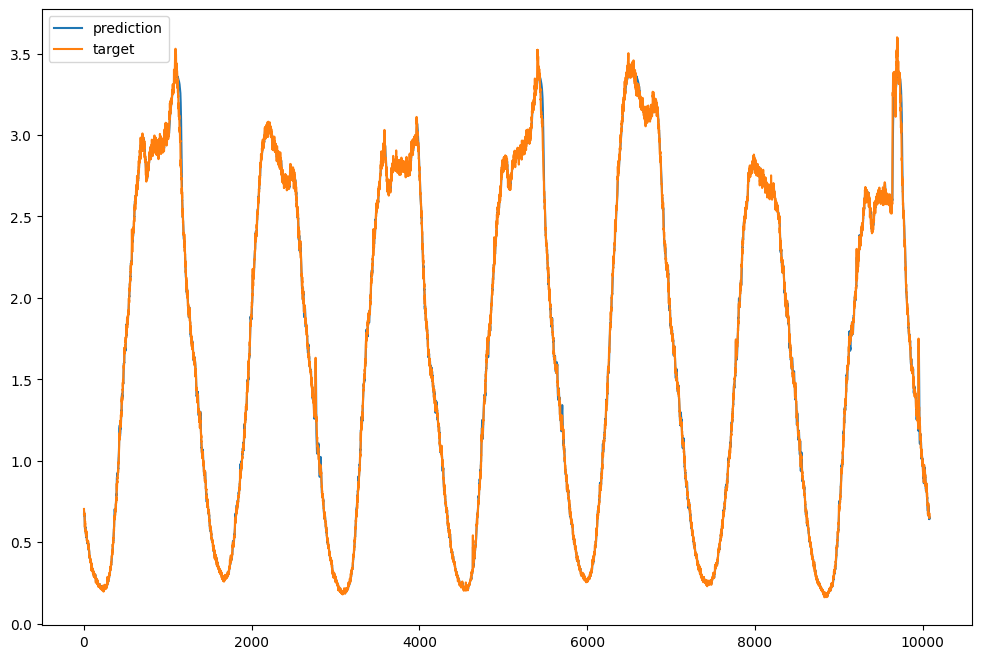

In [17]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [18]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 1.716922640800476 %


SMAPE 0.35495781898498535 %

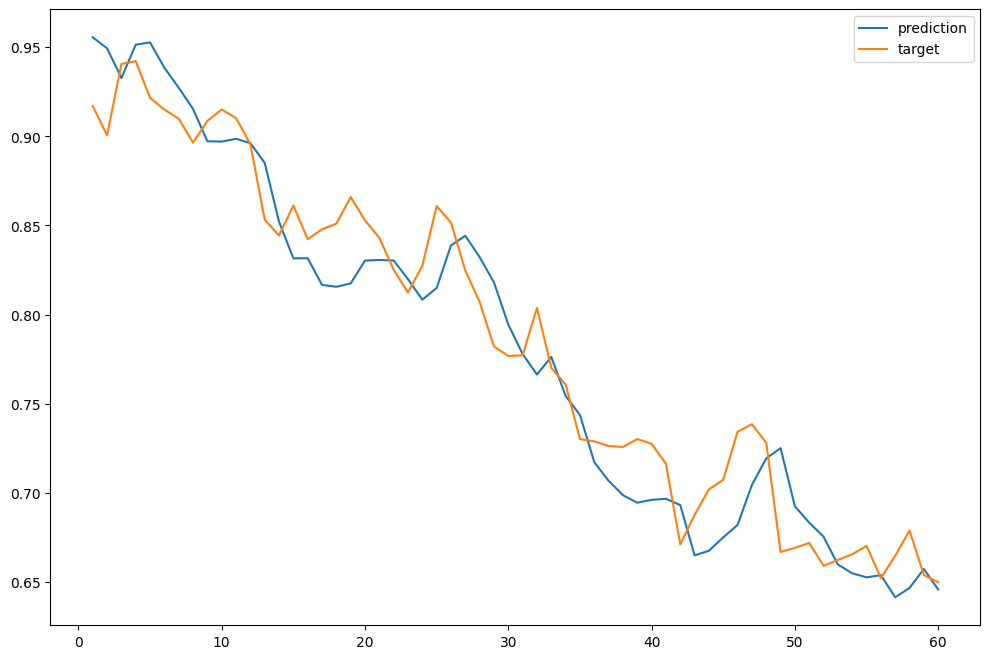

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [21]:
np.mean(time_list)

0.704337949648736

<font color = blue><font size = 6> Conclusion </font></font><br>
DLienar online-learning과 NLinear online-learning에 비하면 매우 안좋은 SMAPE값이다 또한 한번 훈련하는데 0.6초가 걸렸는데 이는 속도가 무려 3배나 느리다는 것을 알려준다